$$
\newcommand{\N}{\mathbb{N}}  % Natural numbers
\newcommand{\Z}{\mathbb{Z}}  % Integers
\newcommand{\R}{\mathbb{R}}  % Real numbers
\newcommand{\C}{\mathbb{C}}  % Complex numbers
\newcommand{\Q}{\mathbb{Q}}  % Rational numbers
\newcommand{\p}{\partial}  %  for partial derivatives
\newcommand{\f}{\frac} % fractions
\newcommand{\mb}{\mathbf}
\newcommand{\tr}{\mathrm{tr}}
%\newcommand{\det}{\mathrm{det}}
\newcommand{\ra}{\Rightarrow}
\newcommand{\upa}{\uparrow}
\newcommand{\lra}{\Leftrightarrow}
\newcommand{\lan}{\langle}
\newcommand{\ran}{\rangle}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\inn}[1]{\lan#1\ran}
\newcommand{\floor}[1]{\lfloor#1\rfloor}
\newcommand{\ol}{\overline}
\newcommand{\cross}{\times}
\newcommand{\F}{\mathbf{F}}
\newcommand{\M}{\mathcal{M}}
\newcommand{\bhat}{\widehat}
%\newcommand{\L}{\mathcal{L}}
%\newcommand{\span}{\textrm{span}}
%\newcommand{\null}{\textrm{null}}
\newcommand{\res}{\textrm{Res}}
\newcommand{\ds}{\displaystyle}
\newcommand{\range}{\textrm{range}}
$$

# STA365 Final Project

# Introduction

In the rapidly evolving automotive market, the ability to accurately predict car prices is invaluable for consumers, manufacturers, and dealers alike. The fluctuating nature of car prices, influenced by factors such as brand reputation, vehicle condition and market trends presents a complex challenge. This project aims to develop a robust car price prediction model that leverages historical data to forecast the selling prices of cars.

The motivation behind this project stems from the growing need for transparency and predictability in the automotive market. Consumers seek to get the best value for their money when purchasing a vehicle, while sellers aim to set competitive prices that reflect the true value of their offerings. By leveraging Bayesian statistics, this project seeks to bridge the gap between expectation and reality, enabling more informed decision-making processes.

To achieve its objectives, the project will employ a variety of machine learning techniques, ranging from Bayesian Linear Regression Model to Robust Bayesian Linear Regression Model. The dataset for this project comprises several features, including the make and model of the car, its age, mileage, fuel type, and condition. Preliminary data analysis will be conducted to understand the dataset's characteristics, identify patterns, and detect any anomalies. We will then do variable selection using Spike and Slab and compare the model performance using WAIC.

In [ ]:
from google.colab import drive
import pymc as pm;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

drive.mount('/content/drive')
car_price_data = pd.read_csv('/content/drive/MyDrive/STA365 project/CarPrice_Assignment.csv')
car_price_data.head()

Mounted at /content/drive


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Our dataset includes detailed information on 205 vehicles, cataloged across 26 attributes such as horsepower, body type, fuel type, and more.

# Exploratory Data Analysis

In [ ]:
# To check missing values
car_price_data[car_price_data.isnull().any(axis=1)]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


In [ ]:
car_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

# Asymmetry and Outliers of the Car Price
The histogram and box-plot of the car price shows the distribution of the car price is not symmetric to the mean with many outliers. This suggests that
1. Fit regression on the Car price directly is not appropriate since it violates the assumption that car price follows a normal distribution. The car prices skews to right and never negative
2. Might need to modify the linear regression model for outliers

To address issue \# 1, we apply the log transformation on the car price data to restore symmetry <br>
To address issue \# 2, we augmented the basic bayesian linear regression by imposing a horseshoe prior on the distributions of coefficients and residuals

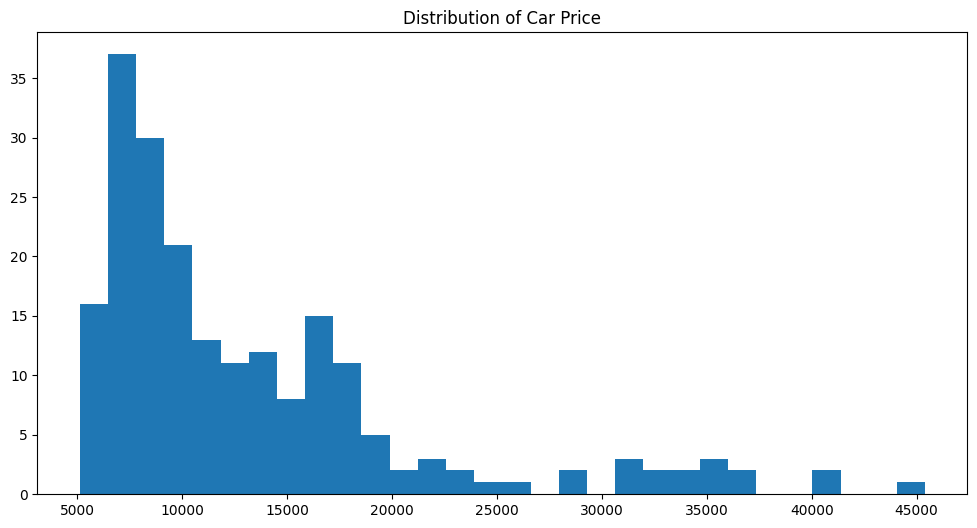

In [ ]:
# The distribution of car price
plt.figure(figsize=(12,6))
plt.hist(car_price_data['price'], bins=30)
plt.title('Distribution of Car Price')
plt.show()

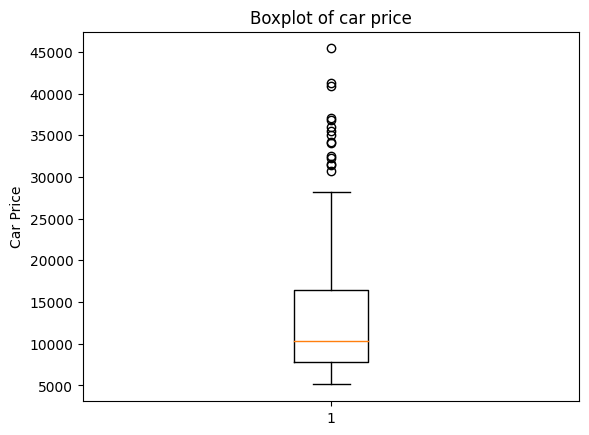

In [ ]:
# Box plot of Car price
plt.boxplot(car_price_data['price'])
plt.title('Boxplot of car price')
plt.ylabel('Car Price')
plt.show()

## Log Transform of Car Price to restore symmetry


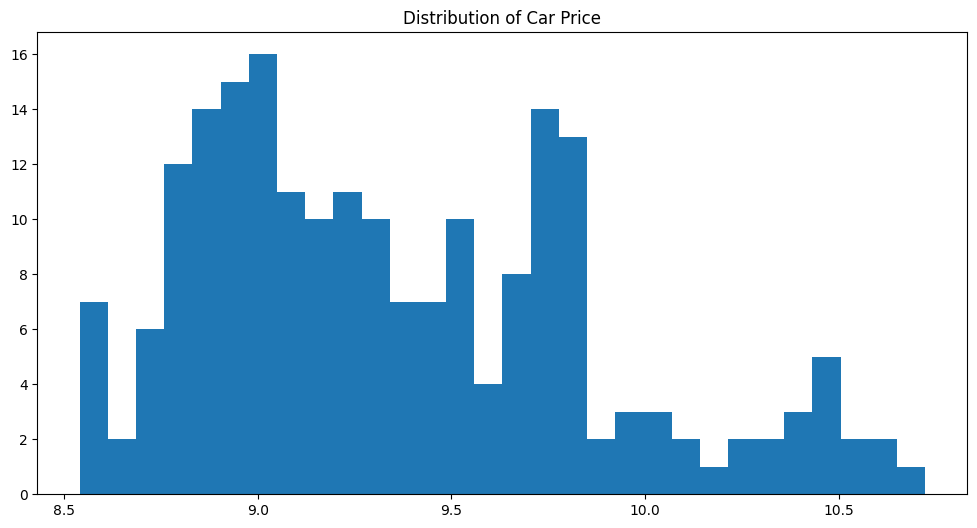

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(np.log(car_price_data['price']), bins=30)
plt.title('Distribution of Car Price')
plt.show()

### Scatter Plots

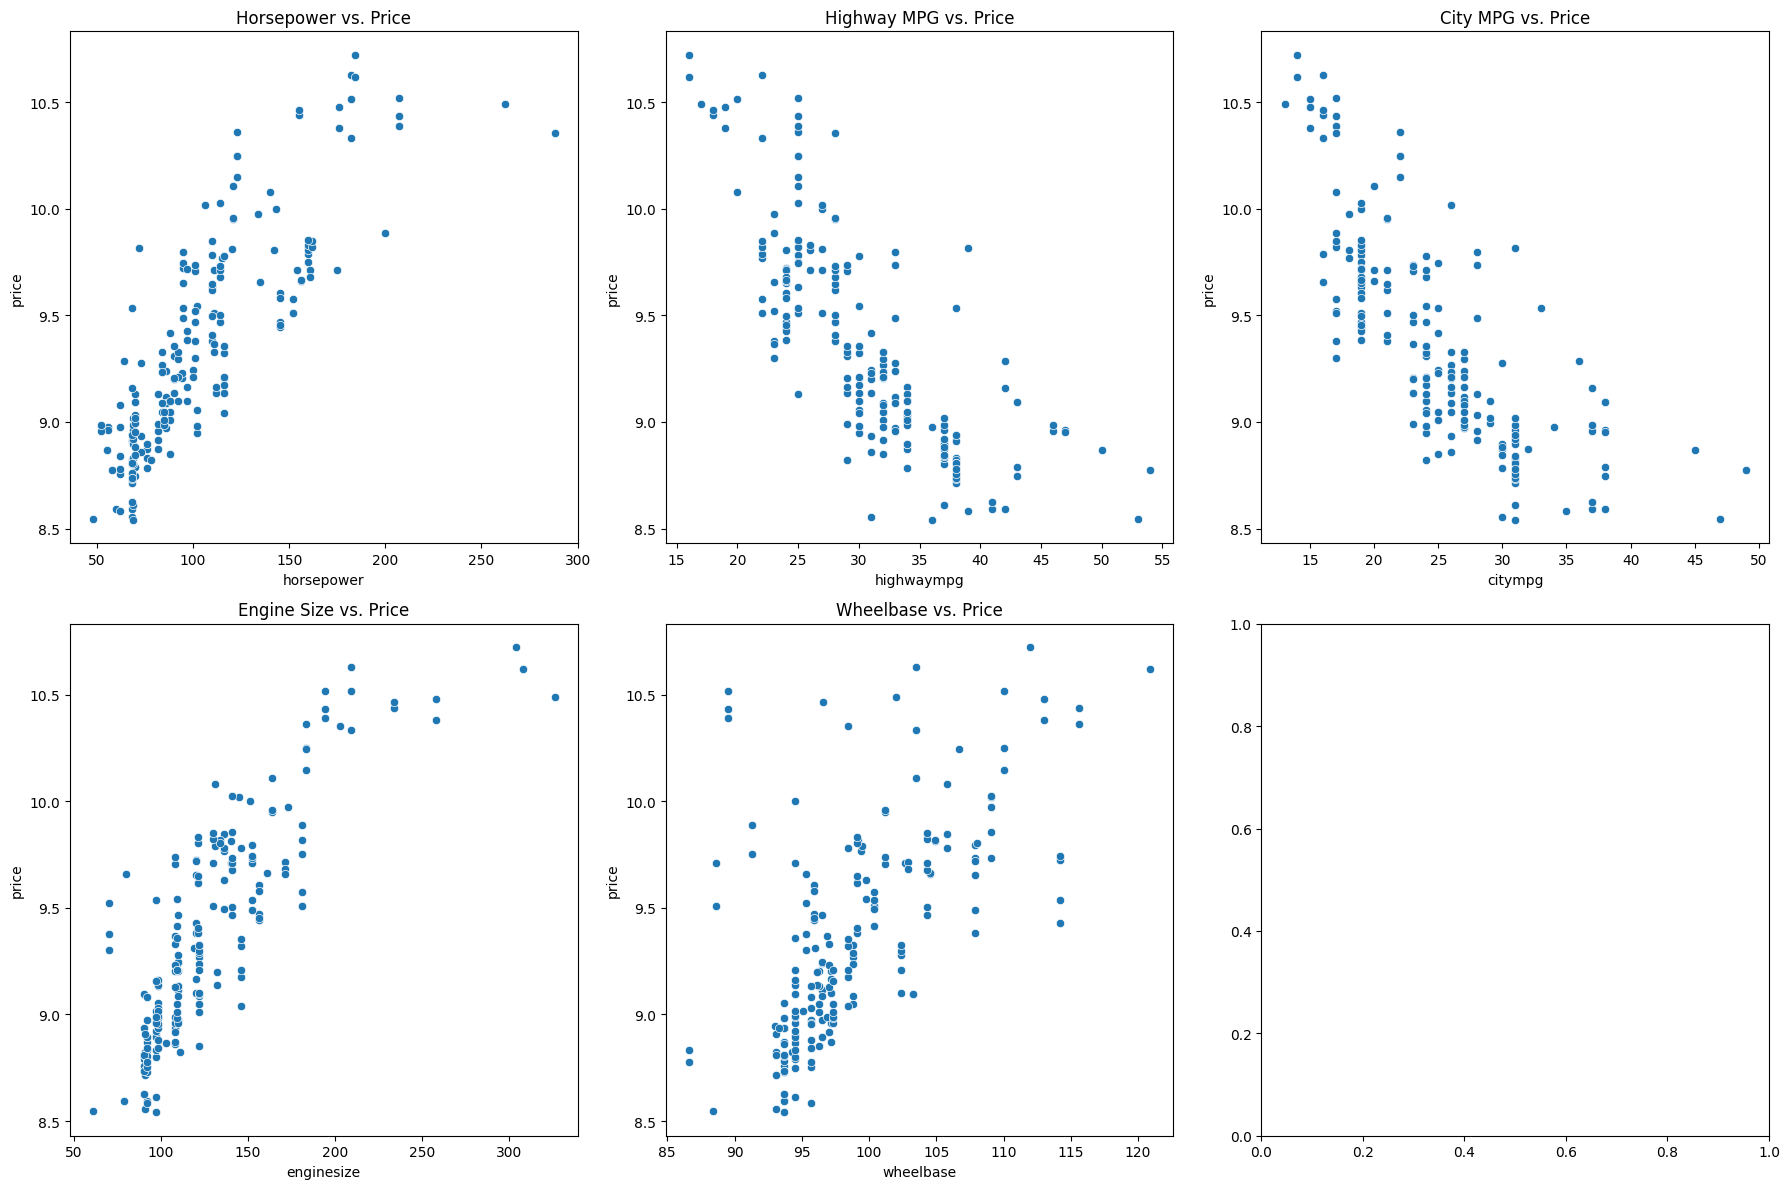

In [ ]:
# Scatter Plots for each predictor vs. price
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
predictors = ['horsepower', 'highwaympg', 'citympg', 'enginesize', 'wheelbase']
titles = ['Horsepower vs. Price', 'Highway MPG vs. Price', 'City MPG vs. Price',
          'Engine Size vs. Price', 'Wheelbase vs. Price']
for i, predictor in enumerate(predictors):
    sns.scatterplot(data=car_price_data, x=predictor, y=np.log(car_price_data['price']), ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(titles[i])
plt.tight_layout()
plt.show()



*   Horsepower vs Price, Engine Size vs Price, and Wheelbase vs Price show a positive trend.
*   Highway MPG vs Price and City MPG vs Price show a negative trend.



## Histograms

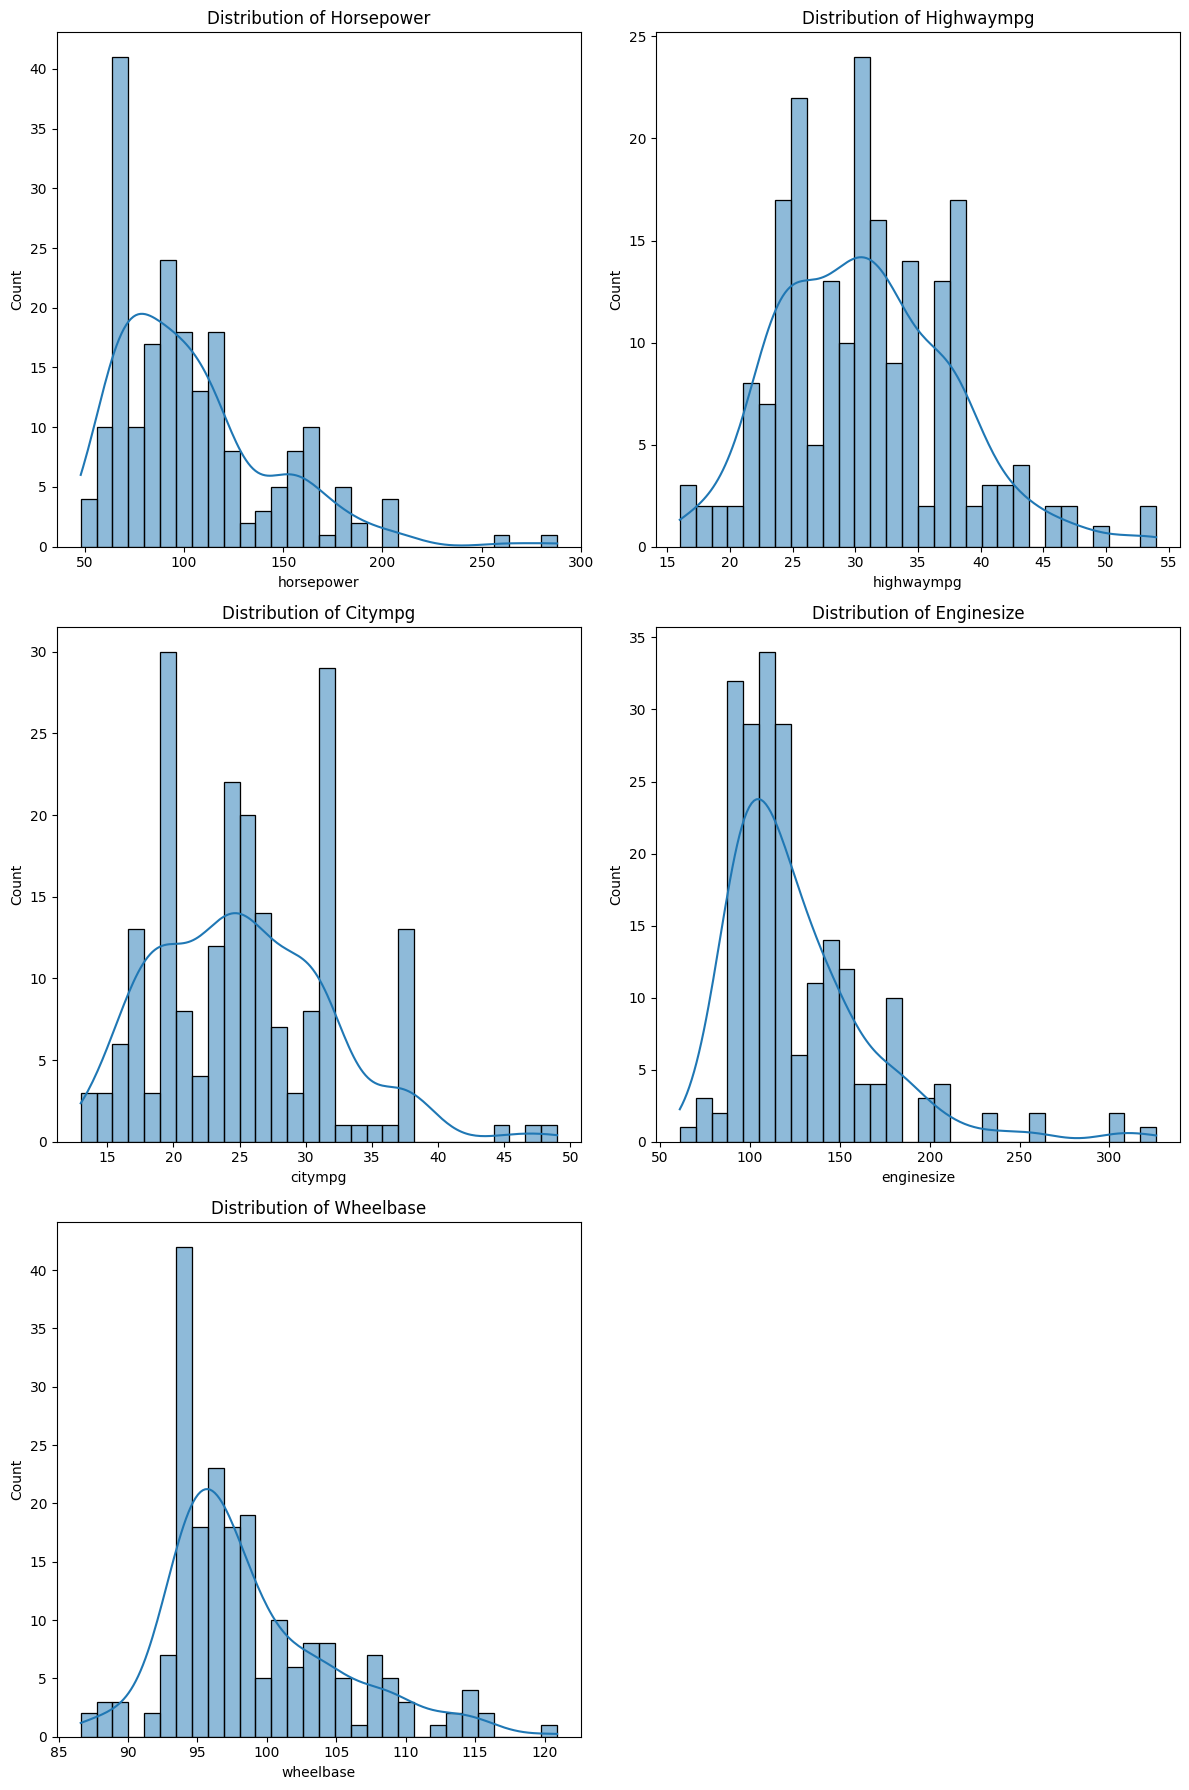

In [ ]:
# Histograms of Predictors
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, predictor in enumerate(predictors):
    sns.histplot(car_price_data[predictor], kde=True, bins=30, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Distribution of {predictor.capitalize()}')
fig.delaxes(axs.flatten()[5])
plt.tight_layout()
plt.show()

The distribution of variables are not quite normally distributed, and some variables such as horsepower and enginesize are right-skewed.

## Box plots

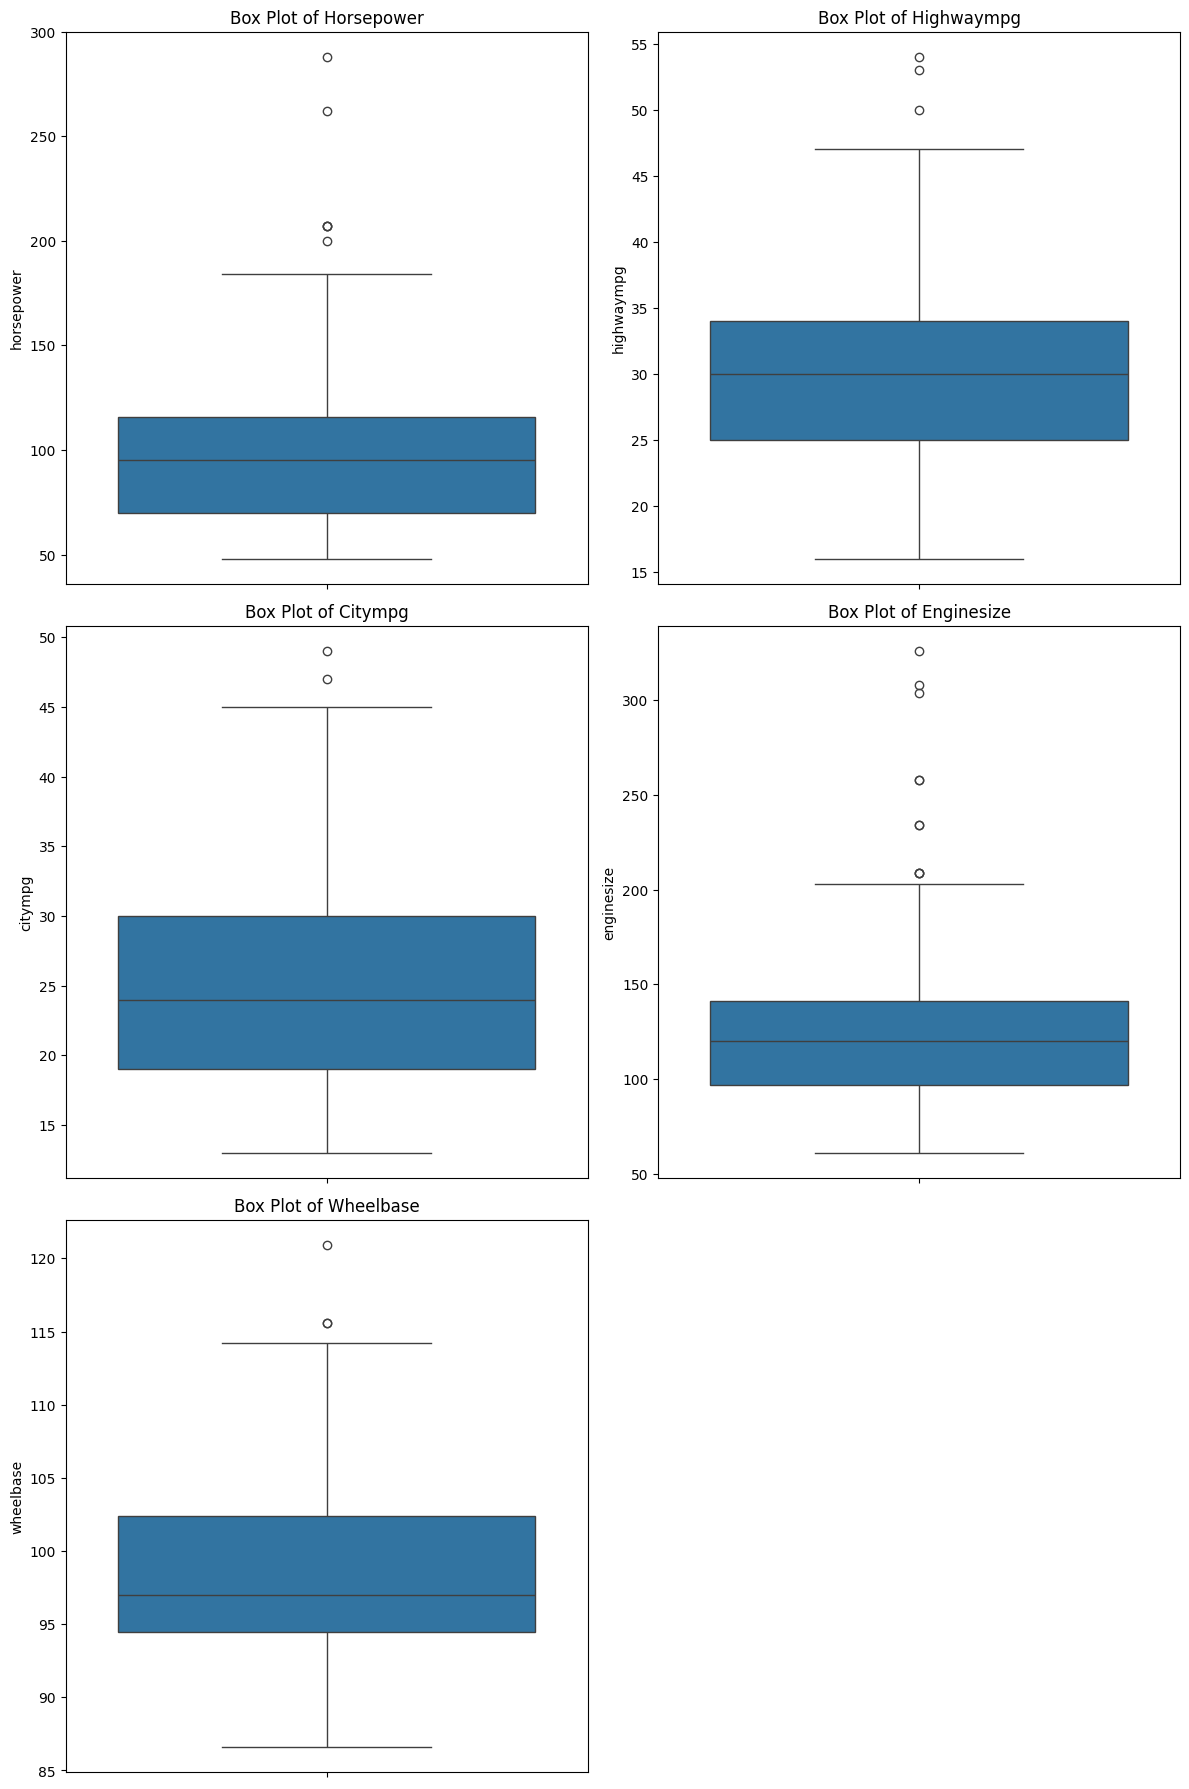

In [ ]:
# Box Plots for each predictor
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
for i, predictor in enumerate(predictors):
    sns.boxplot(data=car_price_data, y=predictor, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Box Plot of {predictor.capitalize()}')
fig.delaxes(axs.flatten()[5]) # Adjusting layout for the last empty subplot
plt.tight_layout()
plt.show()

The boxplots for each predicator present the potential outliers in almost all variables, especially in horsepower and engine size.

# Variable/Predictor Selection - Spike and Slab
1. The Spike and Slab method applies a special form of prior on the regression coefficients $β$. Each coefficient $\beta_{j}$ is associated with two components:


*   **Spike**: A distribution heavily concentrated at zero. This represents the coefficient is irrelevant or has no effect.
*   **Slab**: A wider distribution that allows for a range of non-zero effects. This represents the possibility that the predictor has a significant impact on the response variable.
3. Selection Criteria: Predictors with high probabilities are considered important.


2. Selected variables: ['curbweight','enginesize','horsepower','peakrpm','carlength']


In [ ]:
# data preparation
numeric = car_price_data.select_dtypes(include=[np.number]).columns.tolist()
X_new = car_price_data[numeric].drop(['car_ID','price'], axis=1)
Y = car_price_data['price']
m_new = X_new.shape[1]

In [ ]:
with pm.Model() as spikeNslab:
    lambda_ = pm.Bernoulli('lambda_', p=0.5, shape=m_new)
    spike = pm.Normal('spike', mu=0, sigma=0.001, shape=m_new)  # Spike
    slab = pm.Normal('slab', mu=0, sigma=10, shape=m_new)  # Slab
    beta = pm.Deterministic('beta', lambda_ * slab + (1 - lambda_) * spike)
    sigma = pm.HalfCauchy('sigma', beta=10)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X_new, beta), sigma=sigma, observed=Y)

with spikeNslab:
    idata3 = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:There were 29 divergences after tuning. Increase `target_ac

In [ ]:
summary = az.summary(idata3, var_names=['lambda_'])
predictor_names = X_new.columns.tolist()
summary['Predictor'] = predictor_names
print(summary)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lambda_[0]   0.504  0.500     0.0      1.0      0.004    0.003   14408.0   
lambda_[1]   0.719  0.450     0.0      1.0      0.053    0.038      71.0   
lambda_[2]   0.904  0.295     0.0      1.0      0.016    0.011     347.0   
lambda_[3]   0.649  0.477     0.0      1.0      0.048    0.034     101.0   
lambda_[4]   0.649  0.477     0.0      1.0      0.037    0.026     170.0   
lambda_[5]   1.000  0.000     1.0      1.0      0.000    0.000    4000.0   
lambda_[6]   1.000  0.000     1.0      1.0      0.000    0.000    4000.0   
lambda_[7]   0.502  0.500     0.0      1.0      0.005    0.003   10571.0   
lambda_[8]   0.492  0.500     0.0      1.0      0.004    0.003   14408.0   
lambda_[9]   0.504  0.500     0.0      1.0      0.005    0.004    9661.0   
lambda_[10]  1.000  0.000     1.0      1.0      0.000    0.000    4000.0   
lambda_[11]  0.757  0.429     0.0      1.0      0.210    0.160       4.0   
lambda_[12] 

# Bayesian Linear Regression Model
1. Given a dataset witn $n$ observation and $p$ predictors, we model the relationship betweem $m$ selected predictors $X = [x_1,...,x_m]$ and the natural logarithm of the natural logrithm of the response variable $Y$ (in this case, car prices) as follows:
$log(Y) = \beta_0 + \beta_1 x_1 +...+\beta_m x_m + \epsilon$


*   $log(Y)$ is the natural logarithm of car prices.
*   $x_1,...,x_m$ are the predictors 'curbweight', 'enginesize', 'horsepower', 'peakrpm', 'carlength'.


*   $\beta_0,...,\beta_m$ are the regression coefficients associated with each predictor, including the intercept $\beta_0$.
*   $\epsilon$ represents the error term, assumed to be normally distributed with mean 0 and variance $\sigma^2$


\begin{align*}
  & \beta_0 \sim N(0, 20) \\
  & \beta_j \sim MVN(\vec{0}, I\lambda^2) \\
  & \sigma \sim HalfNormal(1) \\
  & Y| X, \beta_0, \vec{\beta}, \sigma \sim N(X\vec{\beta} + \beta_0, \sigma^2)
\end{align*}, where $\vec{0}$ is a zero vector of length $m$, $I$ is the $m \times m$ identity matrix, and $\lambda^2$ is the variance assigned to each coefficient, indicating the belief about their size.

## Model Construction & Sampling

In [ ]:
new_predictors = ['curbweight','enginesize','horsepower','peakrpm','carlength']
X = car_price_data[new_predictors]
Y2 = np.log(car_price_data['price'])
m = X.shape[1]

In [ ]:
with pm.Model() as BLRM_selected:
    intercept = pm.Normal('intercept', mu=0, sigma=20)
    betas = pm.MvNormal('betas', mu=np.zeros(m), cov=np.eye(m), shape=m)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y = pm.Normal('y', mu=intercept+pm.math.dot(X, betas), sigma=sigma, observed=Y2)
with BLRM_selected:
    idata4 = pm.sample()

## Modeling Diagnostics

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

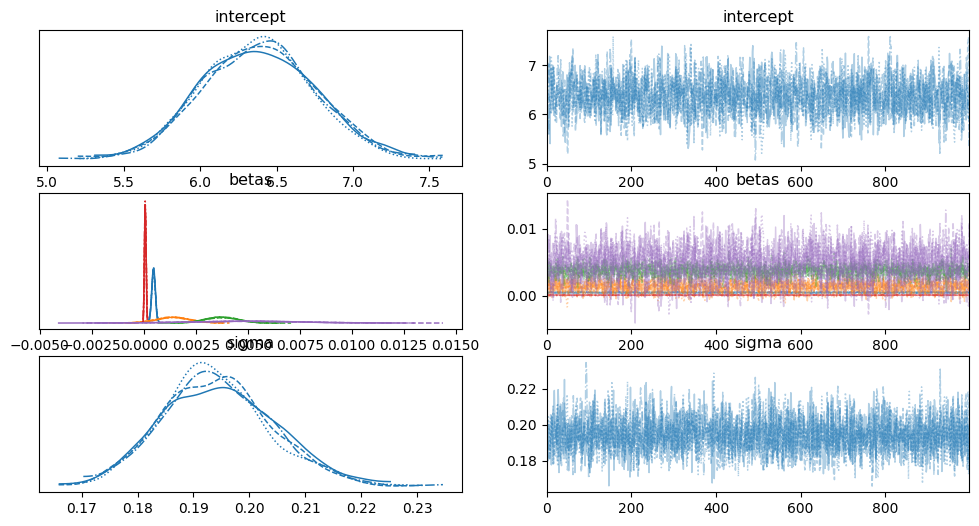

In [ ]:
# Trace plots
az.plot_trace(idata4)

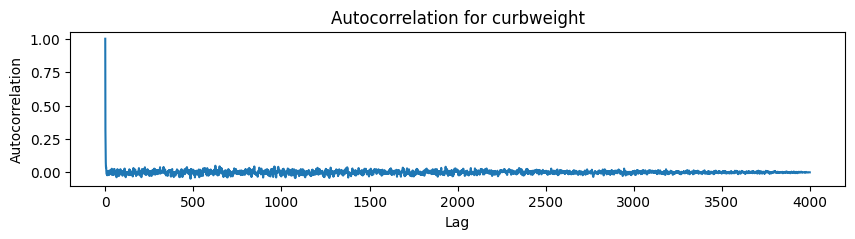

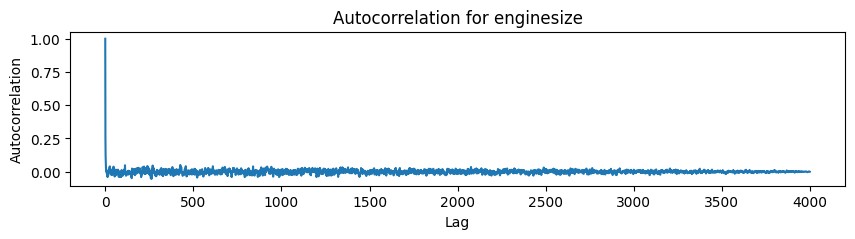

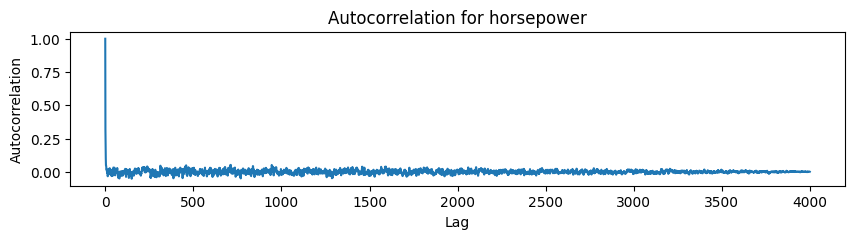

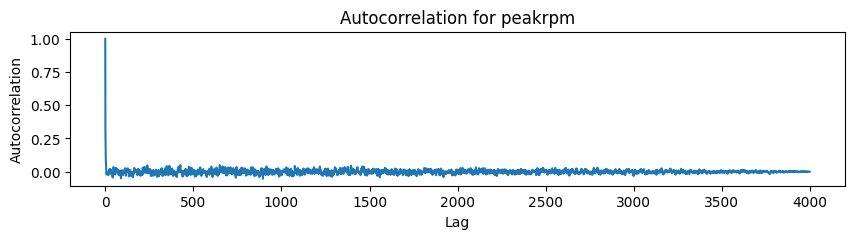

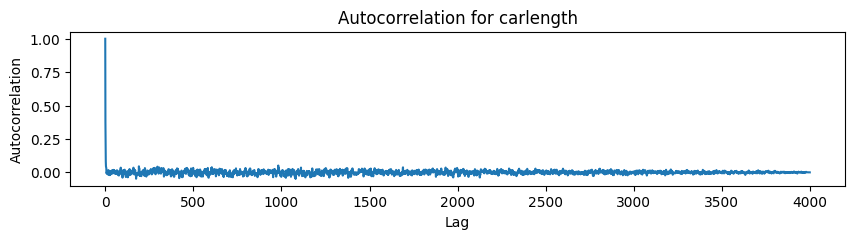

In [ ]:
def autocorr(x):
    result = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    max_corr = result[result.size // 2:]
    return max_corr / max_corr[0]

variable_names = ['curbweight', 'enginesize', 'horsepower', 'peakrpm', 'carlength']
m = len(variable_names)

for i in range(m):
    samples = idata4.posterior['betas'].sel(betas_dim_0=i).values.flatten()
    acorr = autocorr(samples)
    plt.figure(figsize=(10, 2))
    plt.plot(acorr)
    plt.title(f'Autocorrelation for {variable_names[i]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

In [ ]:
# Coefficient table
summary = az.summary(idata4)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,6.380,0.371,5.696,7.074,0.009,0.006,1724.0,2034.0,1.0
betas[0],0.000,0.000,0.000,0.001,0.000,0.000,1779.0,2266.0,1.0
betas[1],0.001,0.001,-0.000,0.003,0.000,0.000,2000.0,2250.0,1.0
betas[2],0.004,0.001,0.002,0.005,0.000,0.000,1610.0,2344.0,1.0
betas[3],0.000,0.000,-0.000,0.000,0.000,0.000,1751.0,2161.0,1.0
betas[4],0.005,0.003,0.000,0.010,0.000,0.000,1631.0,2304.0,1.0
sigma,0.194,0.010,0.177,0.213,0.000,0.000,2960.0,2293.0,1.0


## Posterior Prediction

In [ ]:
with BLRM_selected:
    post_pred = pm.sample_posterior_predictive(idata4, predictions=True)

In [ ]:
log_predictions_dataarray = post_pred.predictions
predictions_original_scale = np.exp(log_predictions_dataarray)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (205) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'y\n0'}>,
        <Axes: title={'center': 'y\n1'}>,
        <Axes: title={'center': 'y\n2'}>,
        <Axes: title={'center': 'y\n3'}>],
       [<Axes: title={'center': 'y\n4'}>,
        <Axes: title={'center': 'y\n5'}>,
        <Axes: title={'center': 'y\n6'}>,
        <Axes: title={'center': 'y\n7'}>],
       [<Axes: title={'center': 'y\n8'}>,
        <Axes: title={'center': 'y\n9'}>,
        <Axes: title={'center': 'y\n10'}>,
        <Axes: title={'center': 'y\n11'}>],
       [<Axes: title={'center': 'y\n12'}>,
        <Axes: title={'center': 'y\n13'}>,
        <Axes: title={'center': 'y\n14'}>,
        <Axes: title={'center': 'y\n15'}>],
       [<Axes: title={'center': 'y\n16'}>,
        <Axes: title={'center': 'y\n17'}>,
        <Axes: title={'center': 'y\n18'}>,
        <Axes: title={'center': 'y\n19'}>],
       [<Axes: title={'center': 'y\n20'}>,
        <Axes: title={'center': 'y\n21'}>,
        <Axes: title={'center': 'y\n22'}>,
        <Axes: t

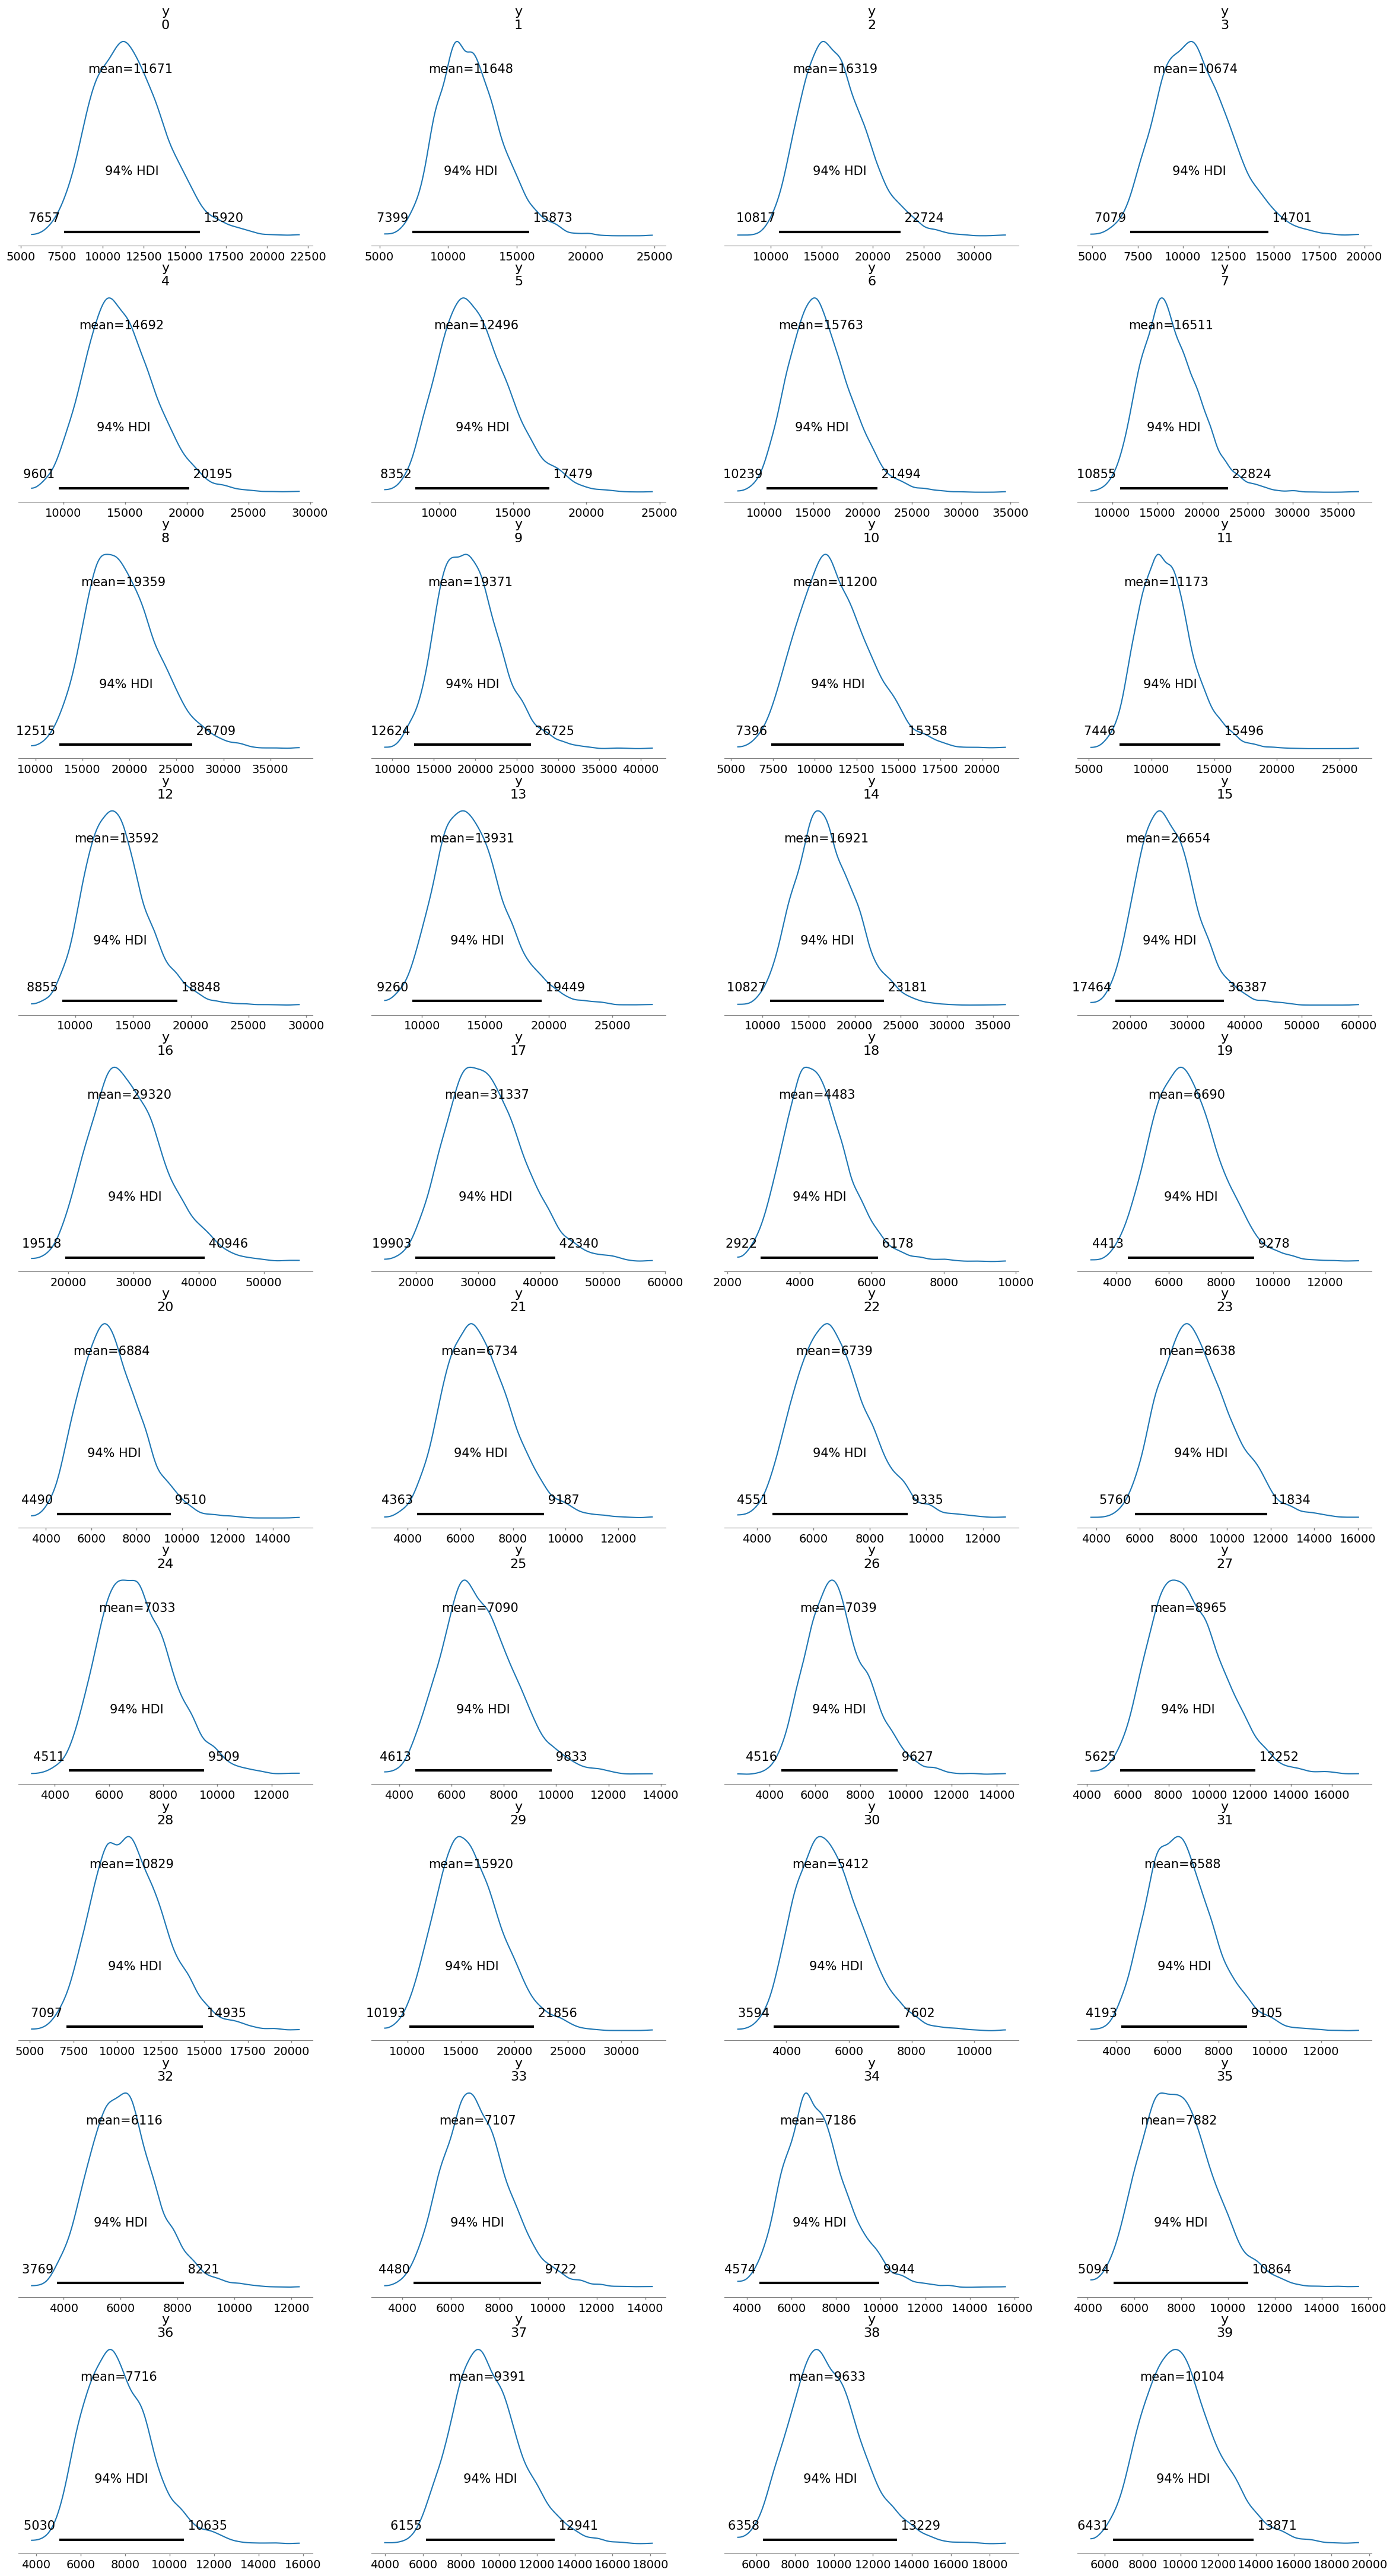

In [ ]:
az.plot_posterior(predictions_original_scale, group="predictions")

# Robust Bayesian Linear Regression Model

## Horeshore Prior on Coefficients and Outliers
According to previous analysis, we apply the log transform on the car price and build a robust linear baysian regression using Horeshore Prior. In particular, let $y$ be the responds, and $\pmb \beta = (\beta_1,...,\beta_k)$ be the coefficient of k predictors. We assume the following hierical bayesian framework
\begin{align*}
  & y| \mb X, \pmb{\beta} \sim N(\pmb{X \beta}, \sigma^2I) \\
  & \sigma \sim HalfCauchy(1) \\
  & \beta_i \sim N(0, \tau^2*\lambda^2) \\
  & \lambda \sim HalfCauchy(1) \\
  & \tau \sim HalfCauchy(1)
\end{align*}
, where $\tau$ and $\lambda$ are the gobal and local shrinkage parameter. In the case when $\sigma^2=\tau^2 = 1$ (i.e. determinsitc with value 1), we have
$$
  E(\beta_i|y) = (1-\kappa_i)y_i
$$
, where $\kappa_i = \f{1}{1+\lambda_i^2}$. Through this formula, we can cleanly see why we call $\lambda$ as a shrinkage parameter.




## Model Construction & Sampling

In [ ]:
with pm.Model() as MLR_Horeshore:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    #tau = pm.HalfCauchy('tau', beta=1)  # Global shrinkage parameter
    #tau = pm.Deterministic('tau', 1.)
    lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=X.shape[1])  # Local shrinkage parameter
    betas = pm.MvNormal('betas', mu=np.zeros(m), cov=1.*lambda_*np.eye(m), shape=m) # Horseshoe prior for coefficients

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma, observed=Y2)

In [ ]:
# Sampling
with MLR_Horeshore:
    idata_h = pm.sample()

## Model Diagnostics

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

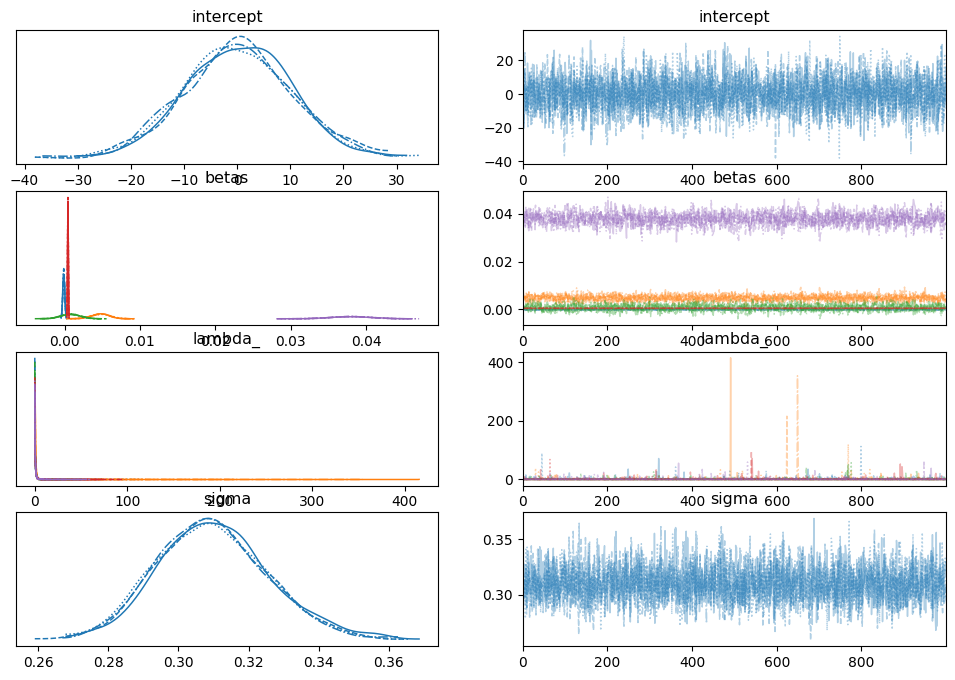

In [ ]:
# Trace plots
az.plot_trace(idata_h)

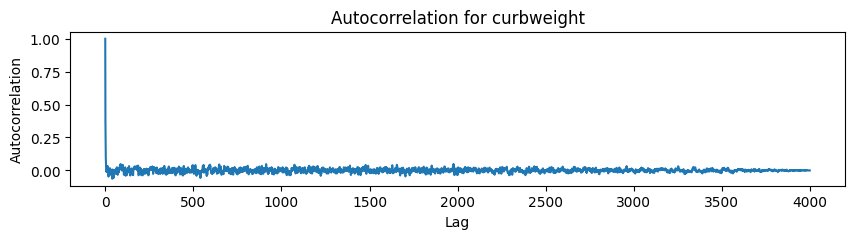

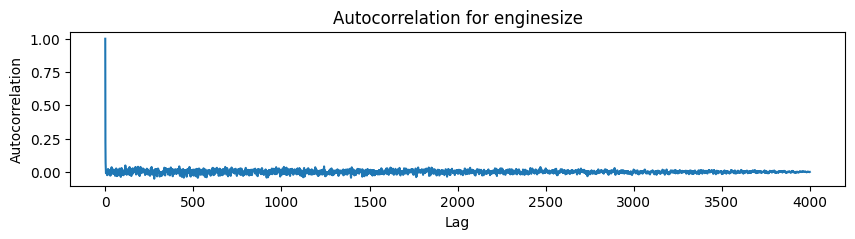

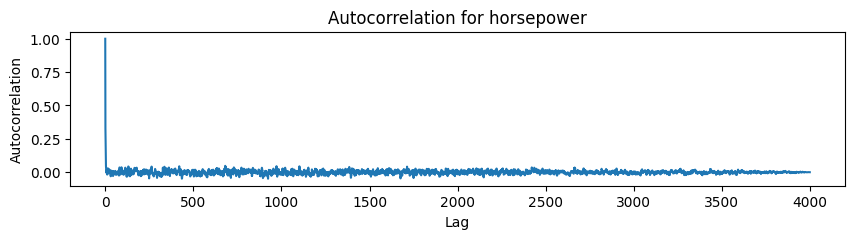

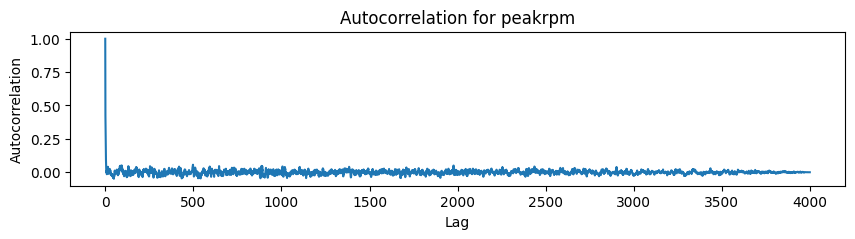

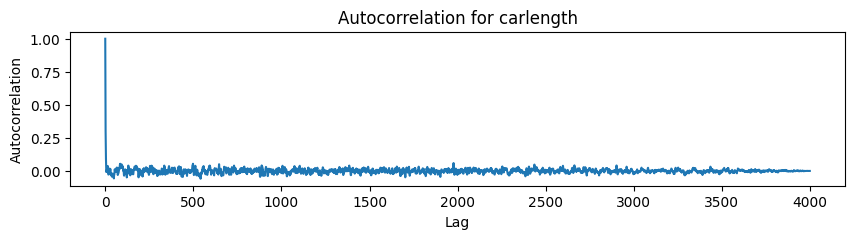

In [ ]:
def autocorr(x):
    result = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    max_corr = result[result.size // 2:]
    return max_corr / max_corr[0]

variable_names = ['curbweight', 'enginesize', 'horsepower', 'peakrpm', 'carlength']
m = len(variable_names)

for i in range(m):
    samples = idata_h.posterior['betas'].sel(betas_dim_0=i).values.flatten()
    acorr = autocorr(samples)
    plt.figure(figsize=(10, 2))
    plt.plot(acorr)
    plt.title(f'Autocorrelation for {variable_names[i]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

In [ ]:
summary = az.summary(idata_h)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.148,10.113,-19.156,19.047,0.177,0.154,3275.0,2650.0,1.0
betas[0],-0.000,0.000,-0.000,0.000,0.000,0.000,1628.0,2399.0,1.0
betas[1],0.005,0.001,0.003,0.007,0.000,0.000,2456.0,2634.0,1.0
betas[2],0.001,0.001,-0.001,0.003,0.000,0.000,1646.0,2116.0,1.0
betas[3],0.000,0.000,0.000,0.001,0.000,0.000,1361.0,1706.0,1.0
betas[4],0.038,0.003,0.033,0.043,0.000,0.000,1269.0,1692.0,1.0
lambda_[0],0.981,3.360,0.000,2.957,0.059,0.042,2761.0,1250.0,1.0
lambda_[1],1.157,10.009,0.000,2.499,0.181,0.128,2896.0,1674.0,1.0
lambda_[2],0.824,2.165,0.000,2.444,0.038,0.027,3037.0,1870.0,1.0
lambda_[3],0.961,3.116,0.000,2.936,0.051,0.036,2646.0,1570.0,1.0


## Posterior Prediction

In [ ]:
with MLR_Horeshore:
    post_pred_horeshore = pm.sample_posterior_predictive(idata_h, predictions=True)

In [ ]:
log_predictions_h = post_pred_horeshore.predictions
predictions_h = np.exp(log_predictions_h)

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (205) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'y_obs\n0'}>,
        <Axes: title={'center': 'y_obs\n1'}>,
        <Axes: title={'center': 'y_obs\n2'}>,
        <Axes: title={'center': 'y_obs\n3'}>],
       [<Axes: title={'center': 'y_obs\n4'}>,
        <Axes: title={'center': 'y_obs\n5'}>,
        <Axes: title={'center': 'y_obs\n6'}>,
        <Axes: title={'center': 'y_obs\n7'}>],
       [<Axes: title={'center': 'y_obs\n8'}>,
        <Axes: title={'center': 'y_obs\n9'}>,
        <Axes: title={'center': 'y_obs\n10'}>,
        <Axes: title={'center': 'y_obs\n11'}>],
       [<Axes: title={'center': 'y_obs\n12'}>,
        <Axes: title={'center': 'y_obs\n13'}>,
        <Axes: title={'center': 'y_obs\n14'}>,
        <Axes: title={'center': 'y_obs\n15'}>],
       [<Axes: title={'center': 'y_obs\n16'}>,
        <Axes: title={'center': 'y_obs\n17'}>,
        <Axes: title={'center': 'y_obs\n18'}>,
        <Axes: title={'center': 'y_obs\n19'}>],
       [<Axes: title={'center': 'y_obs\n20'}>,
        <Axes: tit

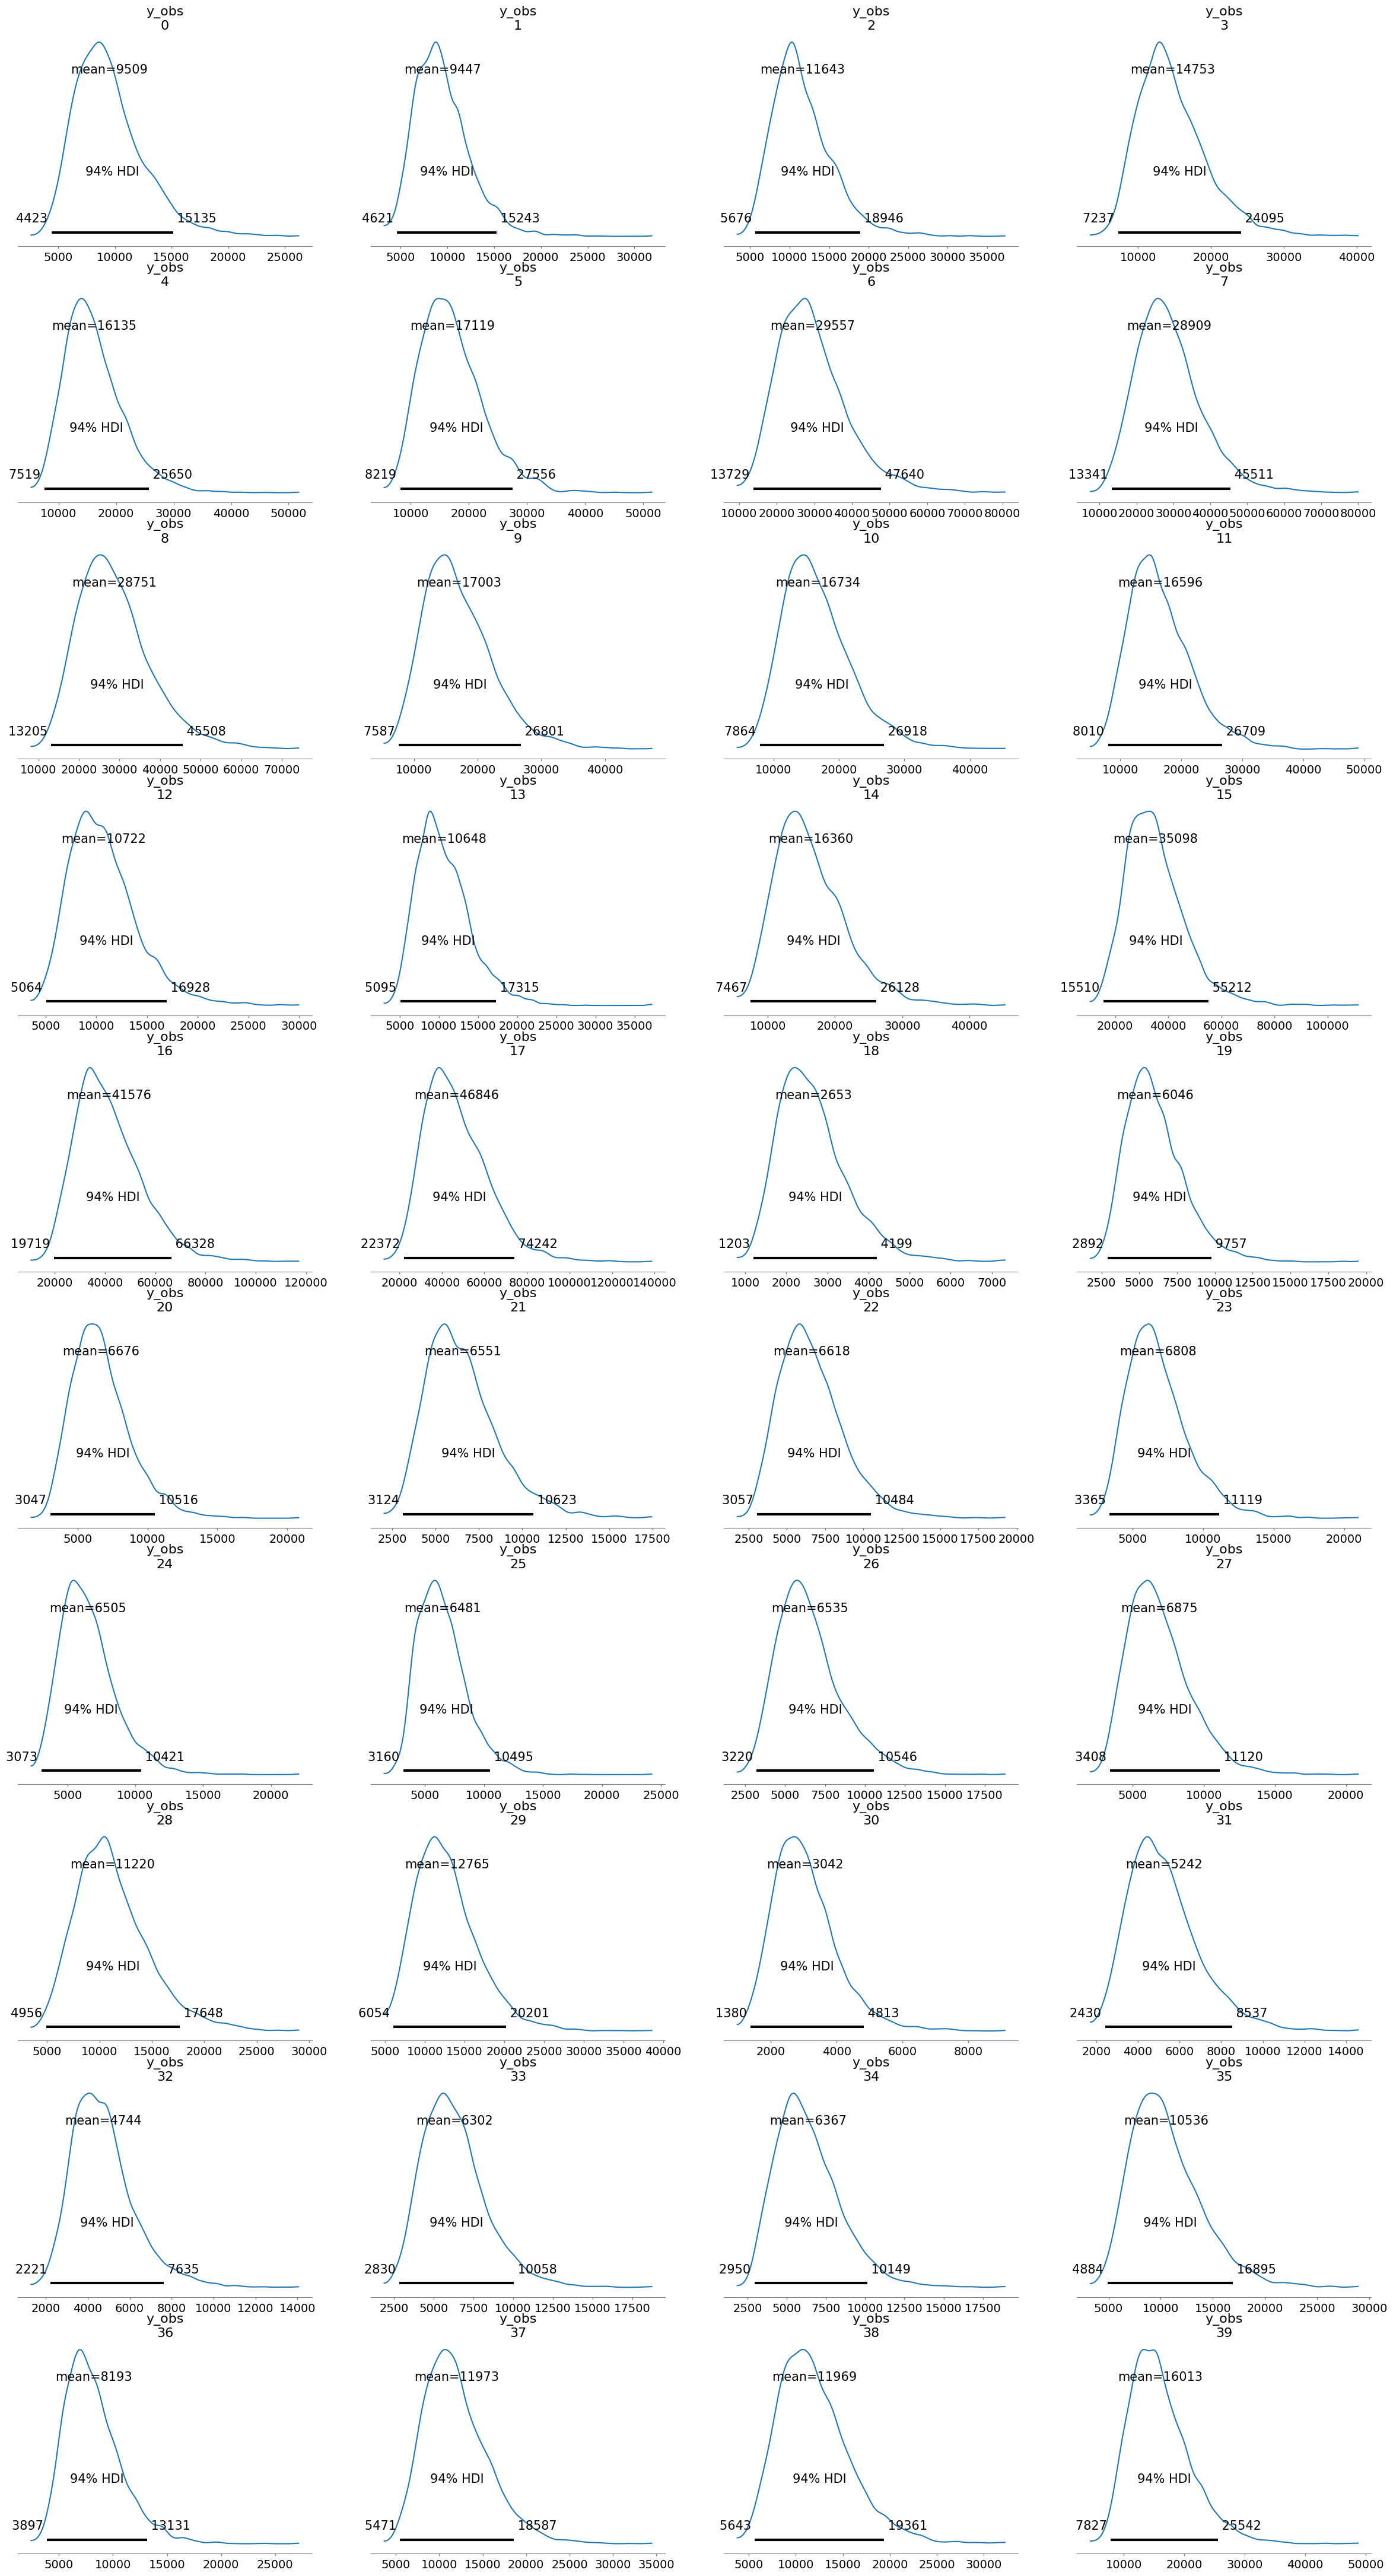

In [ ]:
az.plot_posterior(predictions_h, group="predictions")

# Model Comparison using WAIC
We compare the model performance of basic bayesian linear regression and robust regression model

In [ ]:
with pm.Model() as BLRM_selected_Horeshore:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    #tau = pm.HalfCauchy('tau', beta=1)  # Global shrinkage parameter
    #tau = pm.Deterministic('tau', 1.)
    lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=m)  # Local shrinkage parameter
    betas = pm.MvNormal('betas', mu=np.zeros(m), cov=1.*lambda_*np.eye(m), shape=m) # Horseshoe prior for coefficients

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma, observed=Y2)

In [ ]:
with BLRM_selected_Horeshore:
    idata_horeshore = pm.sample()

In [ ]:
with BLRM_selected:
    pm.compute_log_likelihood(idata4) # or pass `idata_kwargs={"log_likelihood": True}` to `pm.sample`
with BLRM_selected_Horeshore:
    pm.compute_log_likelihood(idata_horeshore)

In [ ]:
az.compare({"Bayesian Linear Regression": idata4, "Robust Linear Regression with Horeshore": idata_horeshore}, ic='loo')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Bayesian Linear Regression,0,41.116346,8.690188,0.000000,1.000000e+00,11.089338,0.00000,False,log
Robust Linear Regression with Horeshore,1,-53.567868,6.640036,94.684214,1.118536e-10,9.774257,9.99592,False,log


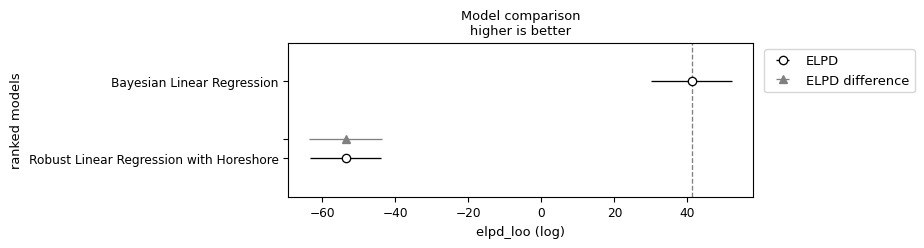

In [ ]:
az.plot_compare(az.compare({"Bayesian Linear Regression": idata4, "Robust Linear Regression with Horeshore": idata_horeshore}), insample_dev=False);